In [1]:
from muler.igrins import IGRINSSpectrum
from muler.hpf import HPFSpectrum

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

import glob
import os
import warnings

import astropy.units as u
# from astropy.io import ascii
# from astropy.io import fits
# from astropy.table import Table, Column, join
# from astropy.wcs import WCS
from astropy.modeling import models, fitting

from specutils import Spectrum1D
from specutils import SpectralRegion
from specutils.fitting import fit_generic_continuum, fit_continuum, fit_lines, find_lines_threshold
from specutils.analysis import equivalent_width
from specutils.manipulation import noise_region_uncertainty

import scipy.integrate as integrate
# from scipy.integrate import trapz
from scipy.optimize import curve_fit

%matplotlib inline
%config InlineBackend.figure_format='retina'
%config Completer.use_jedi = False

In [2]:
# Plotting Parameters
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] =18
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'

In [3]:
# Path for Reduced data .txt files
data_path = "A:/Documents/Grad_School/Research/IGRINS_Merged/"
# File path for figures to live in
fig_path = "A:/Documents/Grad_School/IGRINS-Spectra/IGRINS_figs/standards_spectra/"

# Create the folder if it doesn't exist
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

# Nicole's merged K-band spectra of some Taurus Standards
merged_standard_files = glob.glob(data_path+"merged_standards//m*.txt")

# NIR Lines in micron
nir_dict = {
    "Fe-2.084"  :     2.084,
    "Si-2.092"	:	2.092,
    "Mg-2.106"	:	2.106,
    "Al-2.11"	:	2.11,
    "Ca-2.2035"	:	2.2035,
    "Fe-2.2037"	:	2.2037,
    "Sc-2.2052"	:	2.2052,
    "Na-2.2052"	:	2.2052,
    "Si-2.2063"	:	2.2063,
    "Sc-2.2065"	:	2.2065,
    "Si-2.2073"	:	2.2073,
    "Fe-2.2079"	:	2.2079,
    "Na-2.2083"	:	2.2083,
    "Ca-2.2113"	:	2.2113,
    "Br-Gamma"  :   2.1655,
    "Ti-2.2218"	:	2.2218,
    "Ti-2.224"	:	2.224,
    "Fe-2.226"	:	2.226,
    "Ti-2.228"	:	2.228,
    "Ti-2.232"	:	2.232,
    "Ca-2.26573":	2.26573,
    "Fe-2.2742"	:	2.2742,
    "Mg-2.281"	:	2.281,
    "Ca-2.2825"	:	2.2825,
    "Fe-2.284"	:	2.284,
    "Ti-2.29"	:	2.29,
    "Ti-2.297"	:	2.297,
    "CO(2-0)-2.29353" :	2.29353,
    "CO(2-0)-2.32265"	:	2.32265,
    "CO(2-0)-2.34327" :	2.34327,
    "CO(2-0)-2.34531" :	2.34531,
    "CO(2-0)-2.3495"	:	2.3495,
    "CO(2-0)-2.35167"	:	2.35167,
    "CO(2-0)-2.35246" :	2.35246,
    "CO(2-0)-2.38295" :	2.38295,
    }

# Strings of the Nir lines
lines_str = list(nir_dict.keys())

# Wavelength values for each NIR line
lines_wav = list(nir_dict.values())

# Just a list of the elemental shorthand symbols
labels = [string.split('-')[0] for string in lines_str]

In [4]:
# Print the list of files we are working with
merged_standard_files

['A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mAnon1_M05.txt',
 'A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mHBC427_K6.txt',
 'A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mHubble4_K8.txt',
 'A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mJH108_M15.txt',
 'A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mLkCa14_K5.txt',
 'A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mLkCa1_M4.txt',
 'A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mLkCa4_M2.txt',
 'A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mV410-Xray5a_M6.txt',
 'A:/Documents/Grad_School/Research/IGRINS_Merged/merged_standards\\mV830Tau_K75.txt']

In [5]:
# Pandas Column IDs
# SNR = SNR per resolution element
igrins_cols = ['Wavelength', 'Flux', 'SNR','zero']

# Create Pandas dataframe for the desired standard
standard_df = pd.read_csv(merged_standard_files[1], delimiter='\s+', comment='#', names=igrins_cols)
# SNR column is an object for some reason, change to float
standard_df['SNR'] = standard_df['SNR'].astype(float)

# No negative flux and require 100 < SNR < 10000
# & (standard_df['SNR'] < 10000)
# & (standard_df['Flux'].gt(0.4e6))
standard_df = standard_df[(standard_df['Wavelength'].gt(2.)) & (standard_df['SNR'].between(100, 1e4))] 

# Wavelength + Flux Arrays
wavlen = standard_df['Wavelength']
flux = standard_df['Flux']

In [6]:
# Just checking the data frame
standard_df

,Wavelength,Flux,SNR,zero
9337,2.00001,74332.5000,390.92535,0.0
9338,2.00002,73631.2970,390.61282,0.0
9339,2.00003,72447.0000,389.09836,0.0
9340,2.00005,71294.1020,392.18698,0.0
9341,2.00006,71495.8980,397.55945,0.0
...,...,...,...,...
42500,2.49617,33573.6990,9466.50000,0.0
42590,2.49773,32766.1000,9863.78120,0.0
42601,2.49792,18577.3010,9349.32710,0.0
42638,2.49856,6377.4902,9921.32910,0.0


# Ti 2.224

In [7]:
# Central wavlenlength (micron)
wave_center = 2.224

center_idx = (wavlen-wave_center).abs().idxmin()
# Size of 1 spectral resolution element
# micron per pixel
spec_res = 1e-5

# Define the edges of the feature along spectral axis (NOT FLUX)
wave_lim1 = wave_center - (50*spec_res)
wave_lim2 = wave_center + (50*spec_res)

# Find the indices for the min and max wavelengths of the spectral feature 
wavemin_idx = (wavlen-wave_lim1).abs().idxmin()
wavemax_idx = (wavlen-wave_lim2).abs().idxmin()

# # Choose spectral regions on either side of spectral feature to define a continuum
contlo_1 = wave_lim1-(125*spec_res)
contlo_2 = wave_lim1

conthi_1 = wave_lim2
conthi_2 = wave_lim2+(125*spec_res)

# # Find the indices for the continuum regions on either side of the spectral feature
contlo_min = (wavlen - contlo_1).abs().idxmin()
contlo_max = (wavlen - contlo_2).abs().idxmin()

conthi_min = (wavlen - conthi_1).abs().idxmin()
conthi_max = (wavlen - conthi_2).abs().idxmin()

In [8]:
# # Extract the filename from the path
# filename = os.path.splitext(os.path.basename(file))[0]
# # Make the title according to the filename
# ax.set_title('Spectrum for {}'.format(filename))

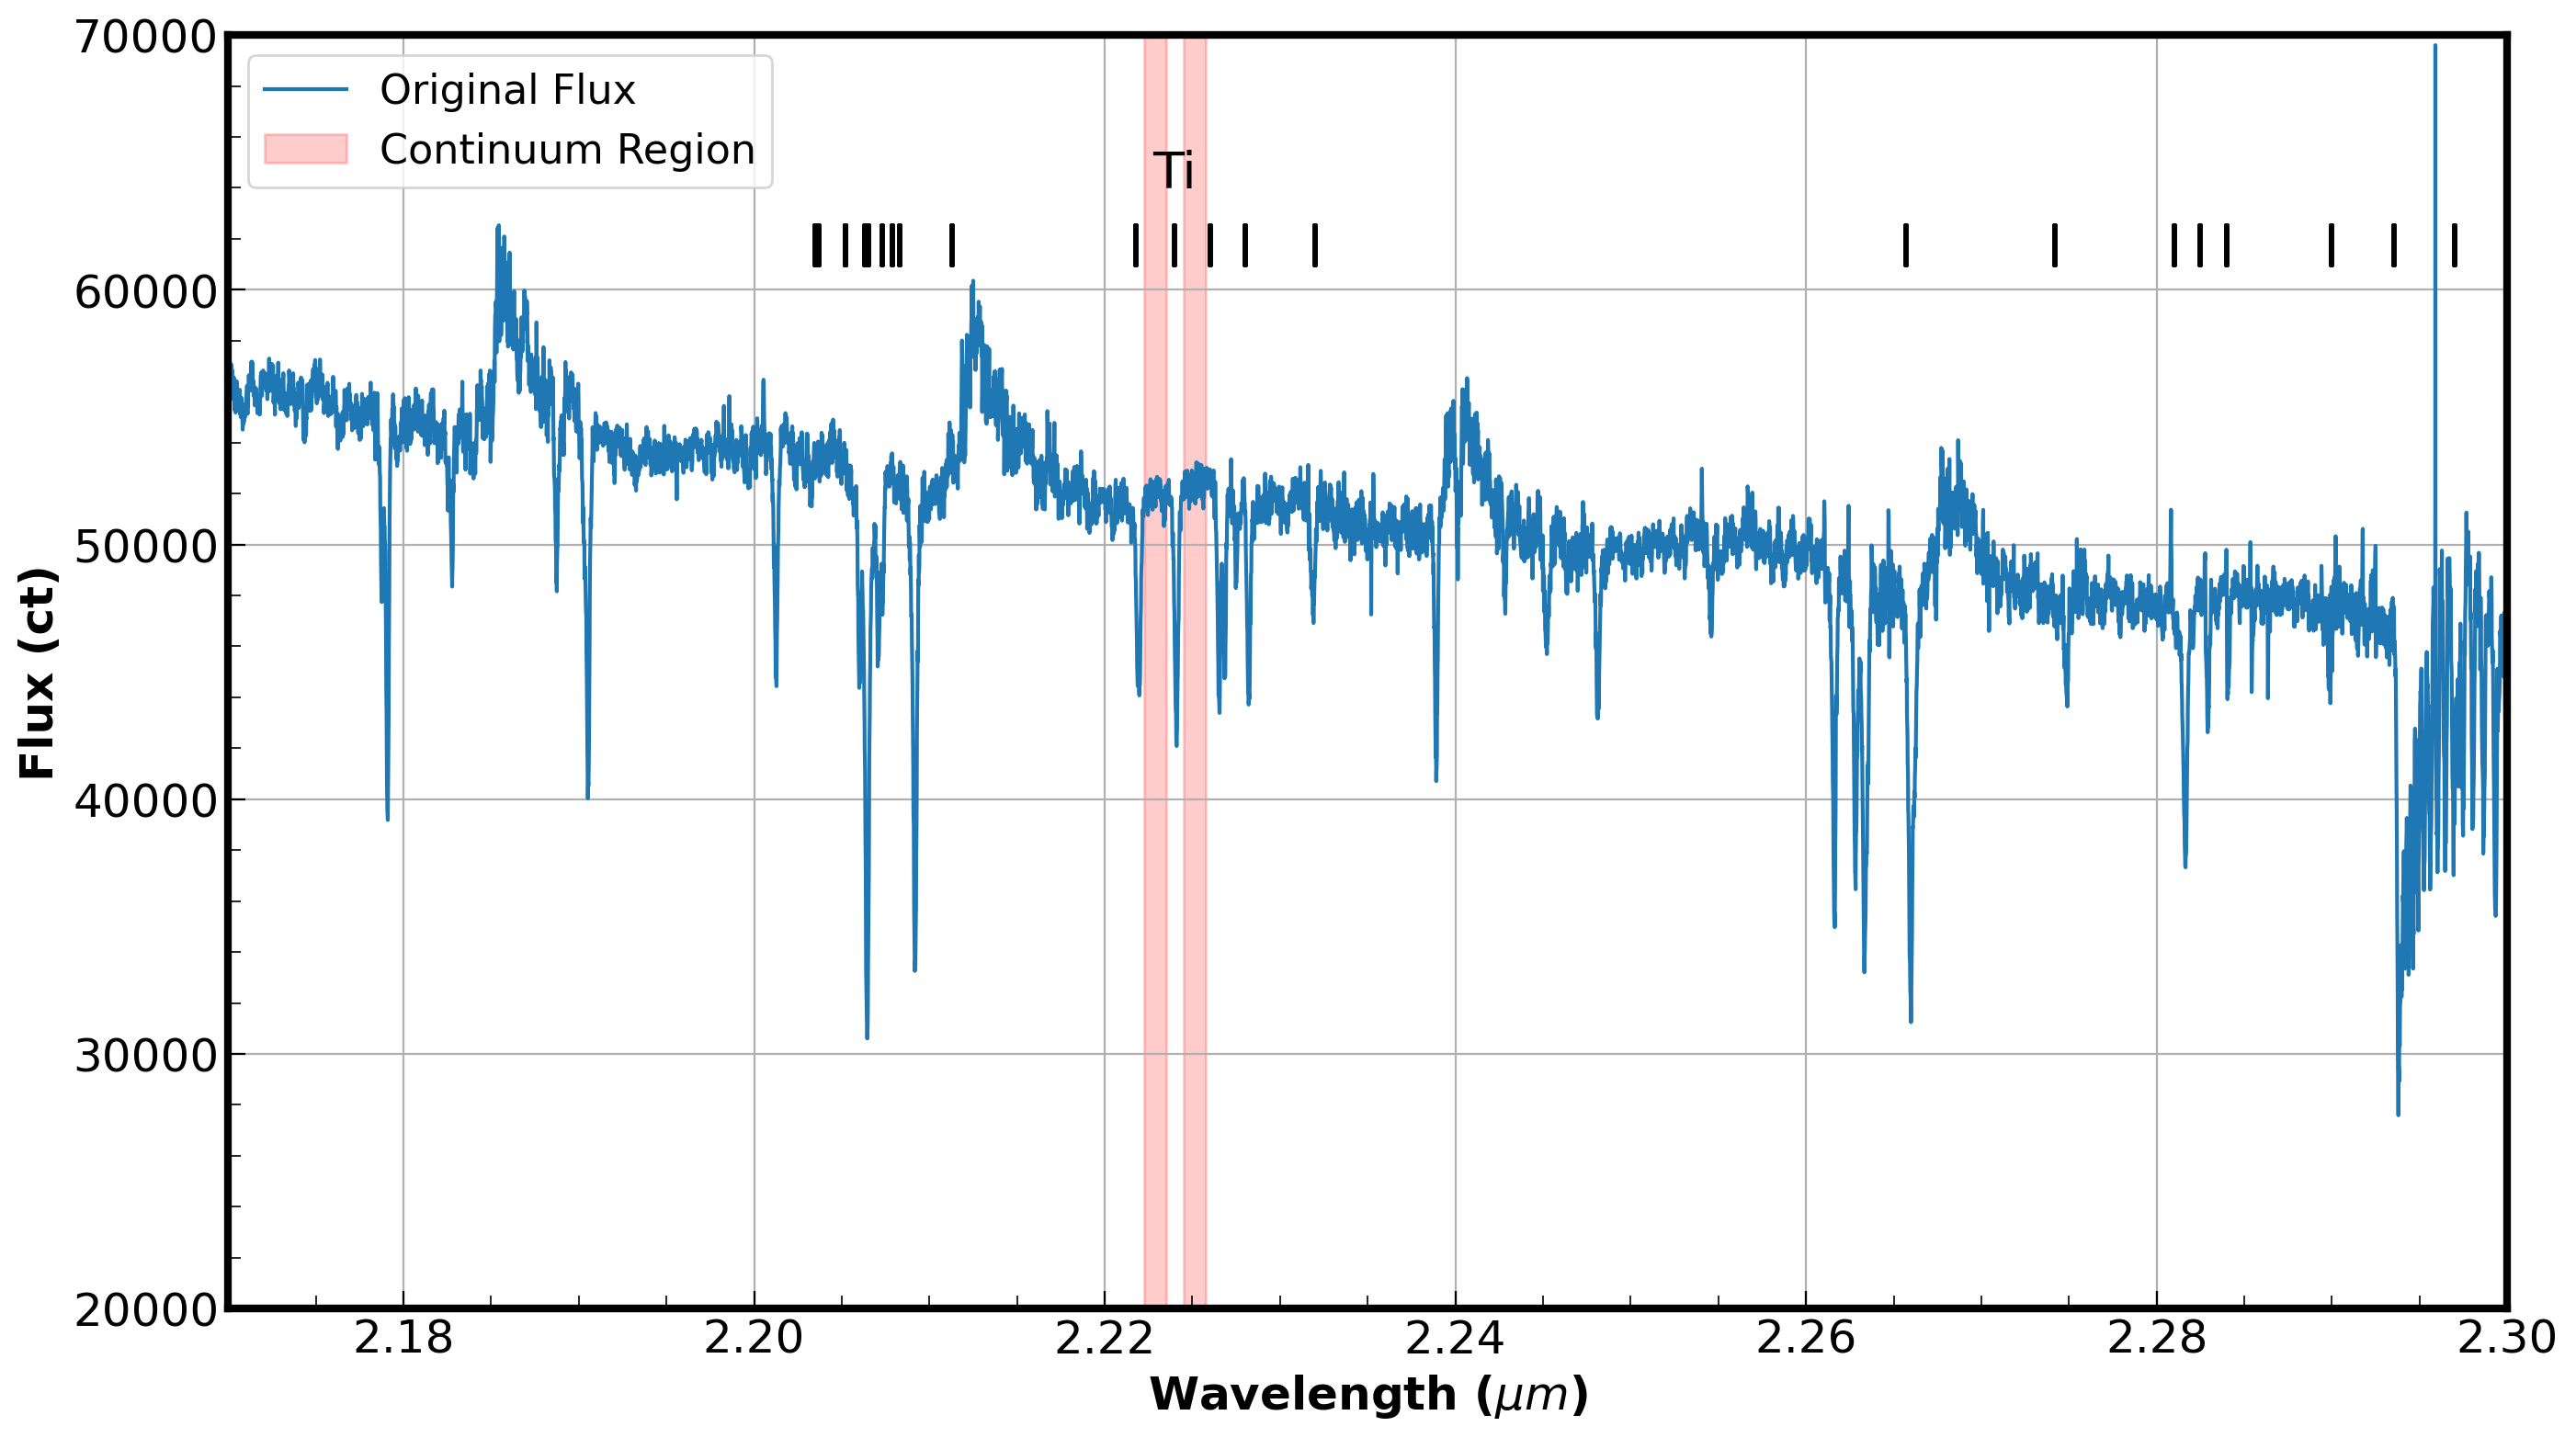

In [24]:
fig,ax = plt.subplots(figsize=(16,9))

plt.plot(wavlen, flux, label='Original Flux')

# Loop through NIR line dictionary and plot vertical, dashed lines at those wavelengths
# Iterate over number of objects
for i in range(len(nir_dict)):
    # Iterate over the NIR dictionary
    for ii in range(len(lines_wav)):
        plt.axvline(lines_wav[ii],0.82,0.85,color='black')
    # ax.text(lines_wav[ii],text_y,labels,ha='center')


plt.axvspan(contlo_1,contlo_2, color='red', alpha=0.2,label='Continuum Region')
plt.axvspan(conthi_1,conthi_2, color='red', alpha=0.2)

text_y = 0.64e5
# ax.text(nir_dict['Ti-2.2218'],text_y,'Ti',ha='center')
ax.text(nir_dict['Ti-2.224'],text_y,'Ti',ha='center')
# ax.text(nir_dict['Fe-2.226'],text_y,'Fe',ha='center')
# ax.text(nir_dict['Ti-2.228'],text_y,'Ti',ha='center')
# ax.text(nir_dict['Ti-2.232'],text_y,'Ti',ha='center')

# Set fig axis limits
plt.xlim(2.17,2.3)
plt.ylim(.2e5,.7e5)

# Enable minor tick marks
ax.minorticks_on()

plt.xlabel('Wavelength ({})'.format('$\mu m$')) 
plt.ylabel('Flux ({})'.format("ct")) 
ax.grid()
plt.legend()
plt.show()

Kurucz(1994)andGoorvitch&Chackerian(1994)

Kurucz,R.L.1994,AtomicDataforOpacityCalculations,KuruczCD–ROMNo.1

Goorvitch,D.&Chackerian,C.Jr.1994,ApJS,91,483

# Local Continuum Fitting

In [10]:
# estimate continuum using mean of points in selected range
# wavelength range of where I'm estimating continuum
contlo_wave = wavlen.loc[contlo_min:contlo_max]
conthi_wave = wavlen.loc[conthi_min:conthi_max]

# fluxe range of where I'm estimating continuum
contlo_flux = flux.loc[contlo_min:contlo_max]
conthi_flux = flux.loc[conthi_min:conthi_max]

contwave_array = np.concatenate((contlo_wave, conthi_wave))
contflux_array = np.concatenate((contlo_flux, conthi_flux))

mean_cont = np.sum(contflux_array)/len(contflux_array)

# estimate continuum using 1d polyfit to points in selected range
cont_fit = np.polyfit(contwave_array, contflux_array, 1)
fitval = np.poly1d(cont_fit)
continuum = fitval(wavlen)

# User input on axis limits here

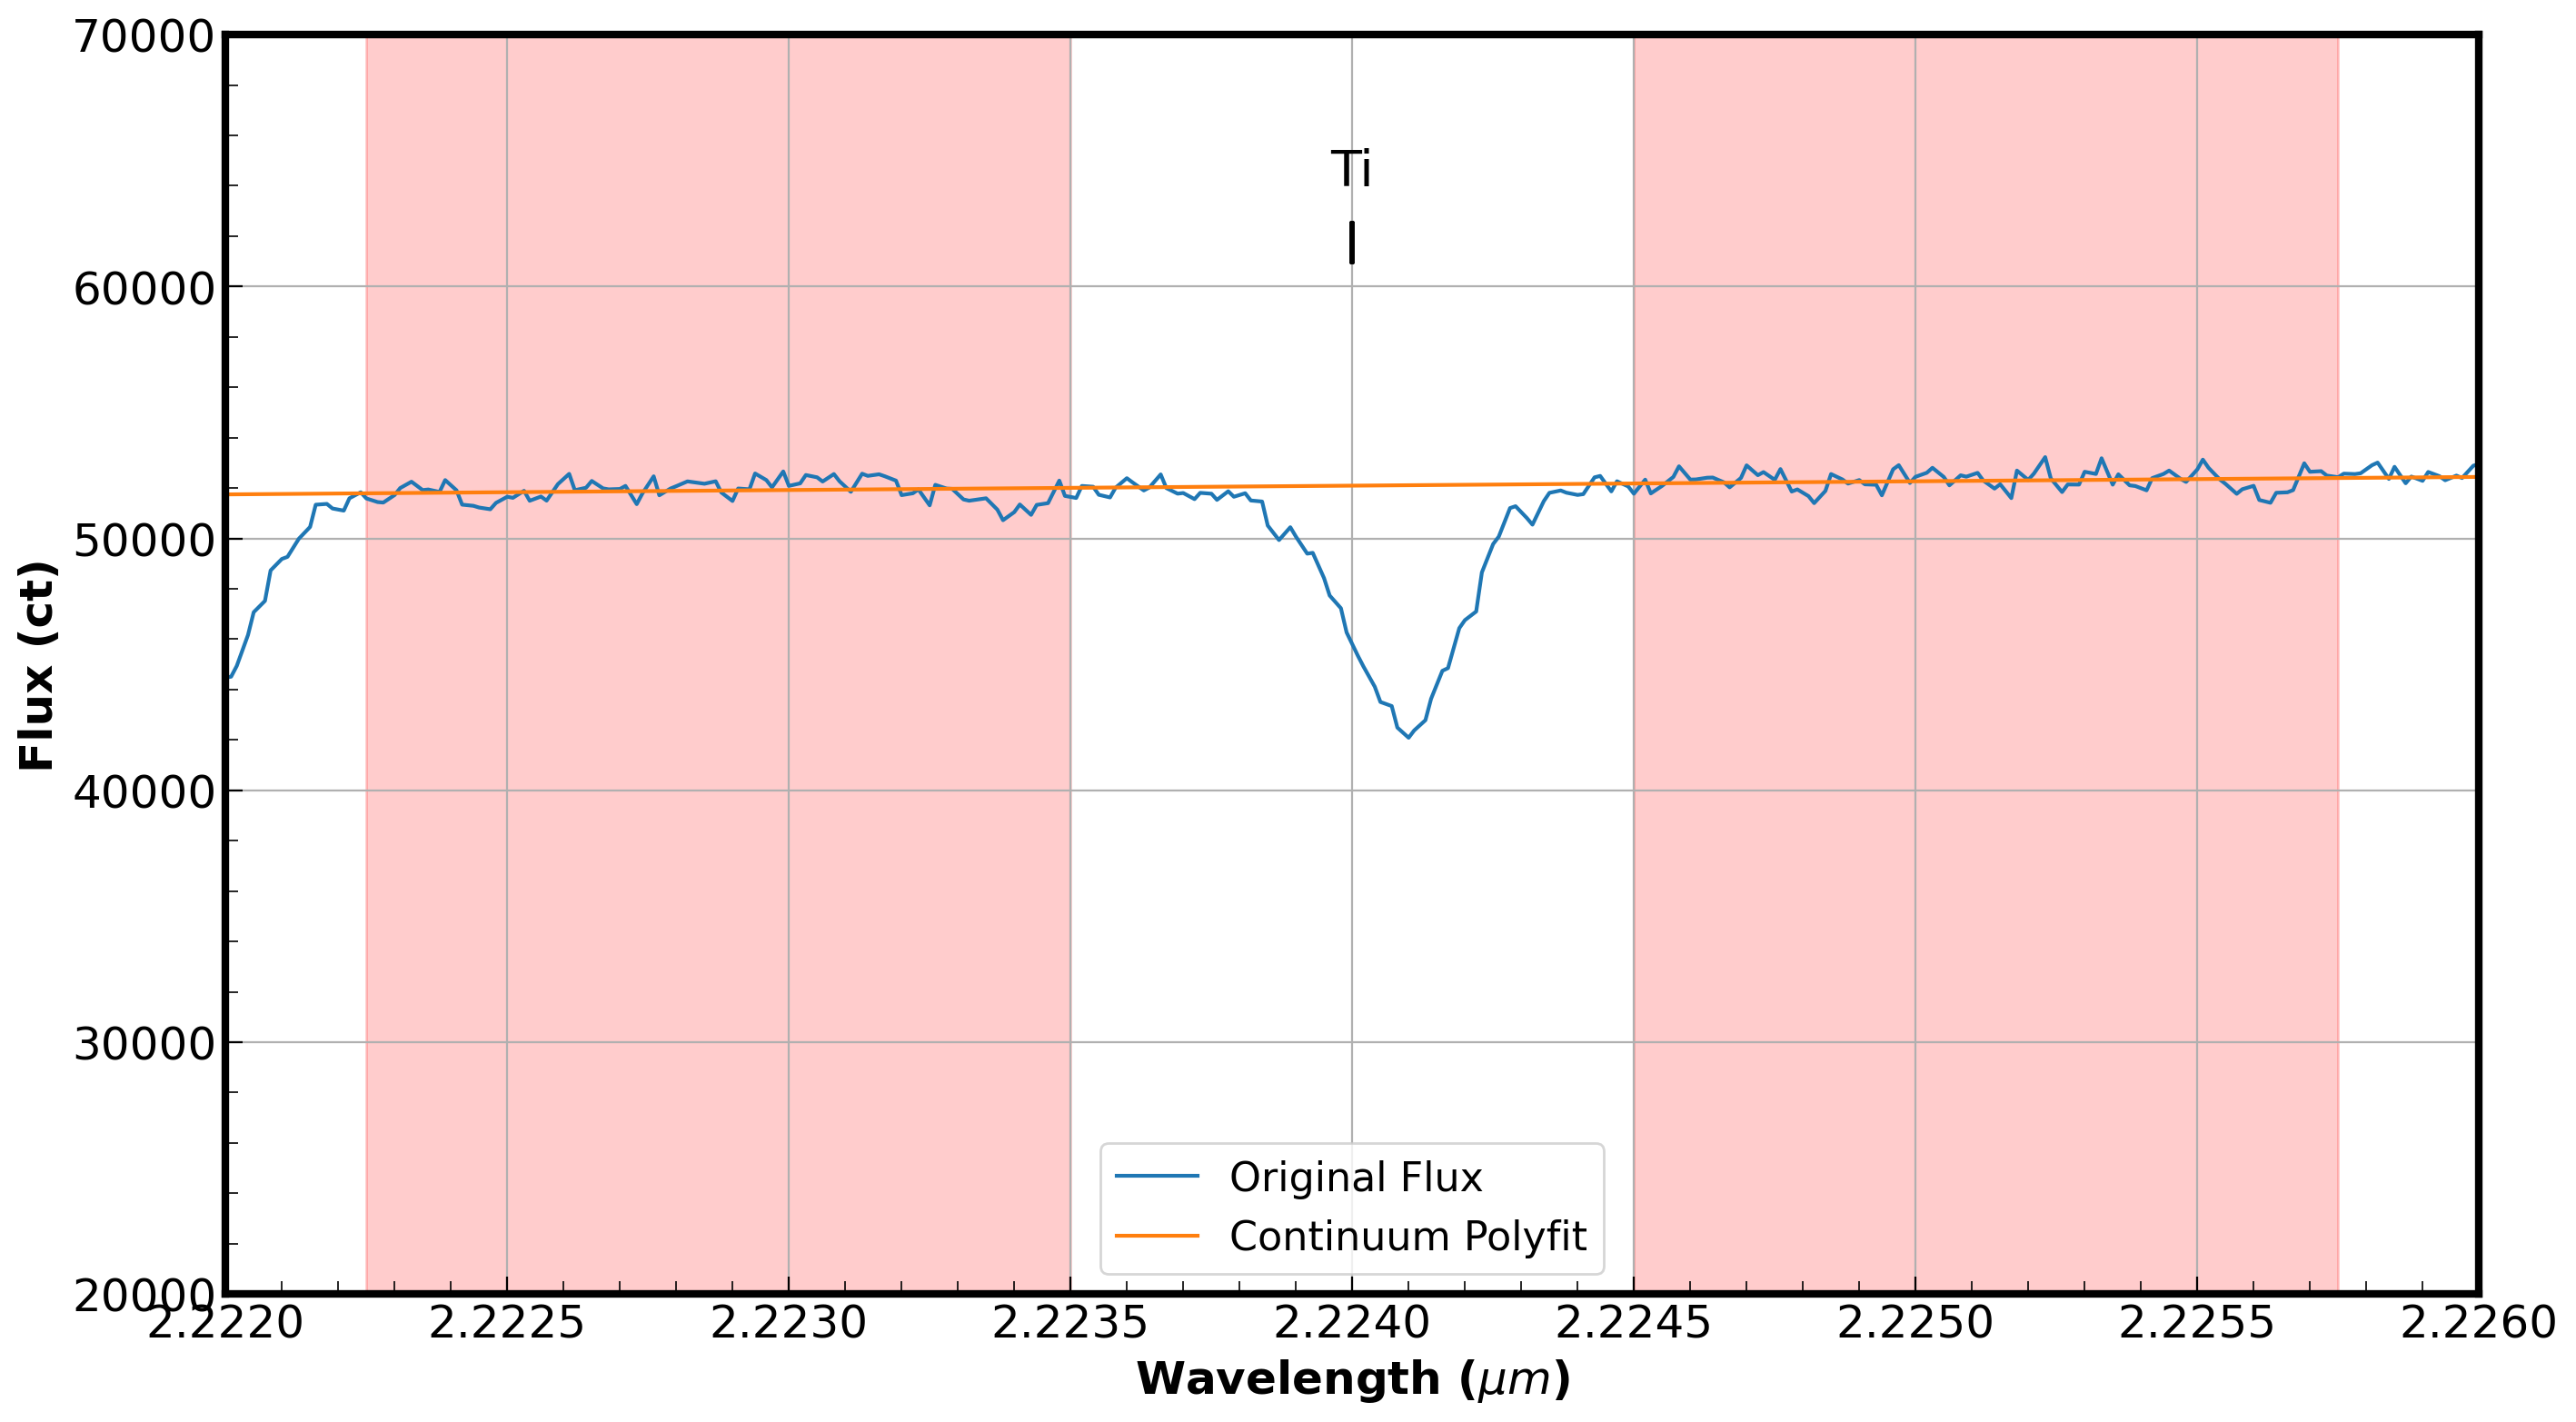

In [11]:
fig,ax = plt.subplots(figsize=(16,9))

plt.plot(wavlen, flux, label='Original Flux')
plt.plot(wavlen, continuum,label='Continuum Polyfit')

# Loop through NIR line dictionary and plot vertical, dashed lines at those wavelengths
# Iterate over number of objects
for i in range(len(nir_dict)):
    # Iterate over the NIR dictionary
    for ii in range(len(lines_wav)):
        plt.axvline(lines_wav[ii],0.82,0.85,color='black')
    # ax.text(lines_wav[ii],text_y,labels,ha='center')


plt.axvspan(contlo_1,contlo_2, color='red', alpha=0.2)
plt.axvspan(conthi_1,conthi_2, color='red', alpha=0.2)


text_y = 0.64e5
# ax.text(nir_dict['Ti-2.2218'],text_y,'Ti',ha='center')
ax.text(nir_dict['Ti-2.224'],text_y,'Ti',ha='center')
# ax.text(nir_dict['Fe-2.226'],text_y,'Fe',ha='center')
# ax.text(nir_dict['Ti-2.228'],text_y,'Ti',ha='center')
# ax.text(nir_dict['Ti-2.232'],text_y,'Ti',ha='center')

# Set fig axis limits
plt.xlim(wave_center-0.002,wave_center+0.002)
plt.ylim(.2e5,.7e5)

# Enable minor tick marks
ax.minorticks_on()

plt.xlabel('Wavelength ({})'.format('$\mu m$')) 
plt.ylabel('Flux ({})'.format("ct")) 

ax.grid()
plt.legend()
plt.show()

In [12]:
cont_sub = flux-continuum # the polyfit continuum-subtracted flux
cont_norm = flux/continuum # polyfit continuum normalized flux

meancont_sub = flux-mean_cont # the mean continuum-subtracted flux
meancont_norm = flux/mean_cont # mean continuum normalized flux

# Gaussian Fitting

$f(x) = \frac{A}{\sigma \sqrt{2\pi}} \exp(-\frac{1}{2}( \frac{x-\mu}{\sigma})^2)$

In [13]:
# Use Normalized Gaussian Distribution
def gaussian_func(x,ampl,center,std,b):
    return ((ampl)/(std*np.sqrt(2*np.pi)) * np.exp(-0.5*(x - center)**2 / (std**2))) + b

# Find the indices for the min and max wavelengths of the spectral feature 
linemin_idx = (wavlen-wave_lim1).abs().idxmin()
linemax_idx = (wavlen-wave_lim2).abs().idxmin()

wavemin = wavlen[linemin_idx]
wavemax = wavlen[linemax_idx]

# initial guesses, need 4 inputs: Amplitude, center, std_dev, b (y offset)
init_params = -1.,  wave_center, .01, wavlen.loc[wavemin_idx:wavemax_idx].min()
# Bounds on the parameters
bounds = ([-10.,0.,0.01,0.95],[10,200.,100.,1.05])

popt, pcov = curve_fit(f=gaussian_func, xdata=wavlen.loc[contlo_min:conthi_max], ydata=cont_norm.loc[contlo_min:conthi_max],p0=init_params, maxfev=10000)

# Gaussian Fit to spectral feature using the best fit parameters
best_model = gaussian_func(wavlen, *popt)

print("Best Fit Parameters:", popt)

Best Fit Parameters: [-4.68168901e-05  2.22409075e+00  1.03058066e-04  9.99558928e-01]


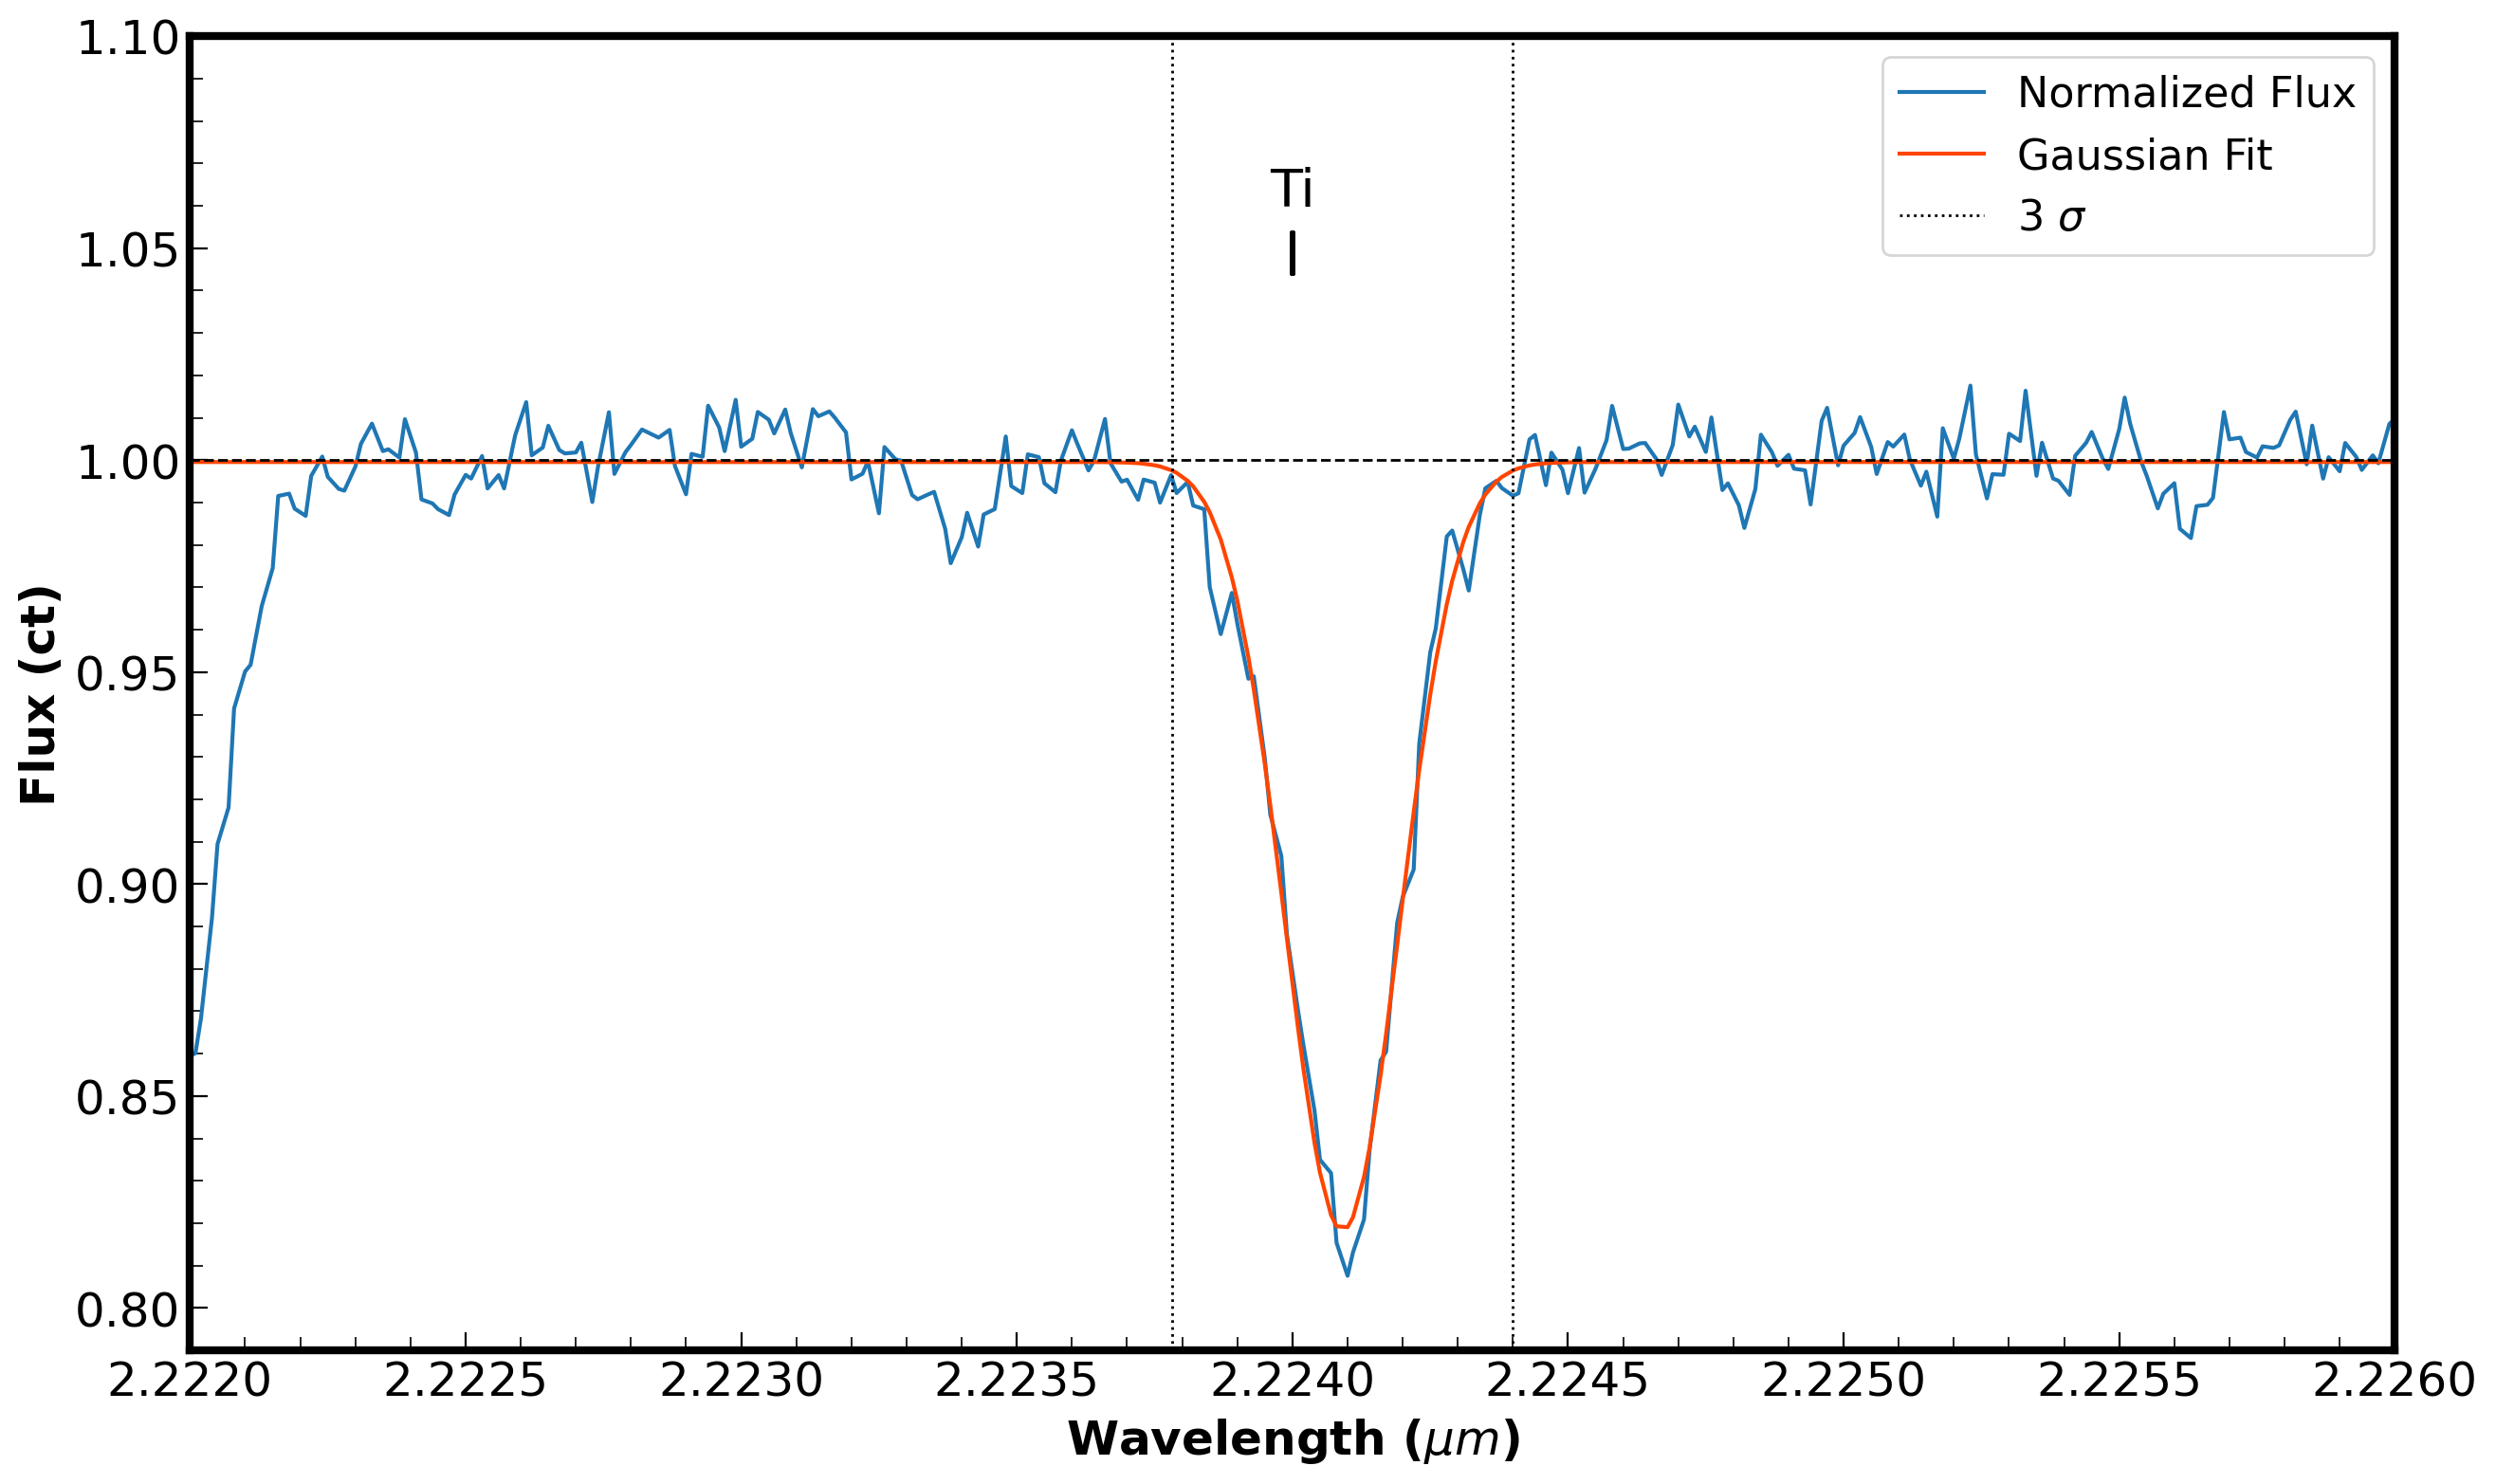

In [15]:
fig,ax = plt.subplots(figsize=(15,9))

plt.plot(wavlen, cont_norm,label='Normalized Flux')
plt.plot(wavlen, best_model,color='orangered', label='Gaussian Fit')

# plt.fill_between(wavlen, y1=best_model, y2=1.0, color='gray', alpha=0.5, label='Line Region')


plt.axhline(y=1, color='black', linewidth=1, linestyle='dashed')
plt.axvline(x=popt[1]+3*popt[2], color='black', linewidth=1, linestyle='dotted',label='3 $\sigma$')
plt.axvline(x=popt[1]-3*popt[2], color='black', linewidth=1, linestyle='dotted')

# Loop through NIR line dictionary and plot vertical, dashed lines at those wavelengths
# Iterate over number of objects
for i in range(len(nir_dict)):
    # Iterate over the NIR dictionary
    for ii in range(len(lines_wav)):
        plt.axvline(lines_wav[ii],0.82,0.85,color='black')
    # ax.text(lines_wav[ii],text_y,labels,ha='center')

# Continuum Estimation region
# plt.axvspan(wavlen[contlo_min],wavlen[contlo_max], color='red', alpha=0.2)
# plt.axvspan(wavlen[conthi_min],wavlen[conthi_max], color='red', alpha=0.2)

text_y = 1.06
ax.text(nir_dict['Ti-2.224'],text_y,'Ti',ha='center')

# Set fig axis limits
plt.xlim(wave_center-0.002,wave_center+0.002)
plt.ylim(0.79,1.1)

# Enable minor tick marks
ax.minorticks_on()

plt.xlabel('Wavelength ({})'.format('$\mu m$')) 
plt.ylabel('Flux ({})'.format("ct")) 
plt.legend(loc='upper right')

plt.savefig(fig_path+'hbc427_Ti_2_224_gauss.png')
plt.show()

In [16]:
# Flux at that central wavelength pixel
center_flux = best_model[center_idx]
print("Flux at Central Wavelength:", center_flux)

center_abs = 1-center_flux
print("Relative Absorption:", center_abs)


# Get FWHM
half_flux = 1-(center_abs/2)
print("Half Max Flux:", half_flux)

half_abs = center_abs/2
print("Half Relative Absorption:", half_abs)

# Need wavelengths where flux is at FWHM?
# (best_model-half_max).abs().idxmin()


Flux at Central Wavelength: 0.8662364437742585
Relative Absorption: 0.13376355622574154
Half Max Flux: 0.9331182218871292
Half Relative Absorption: 0.06688177811287077


In [17]:
# Area under a Gaussian
# Amplitude * Standard Deviation / sqrt(2*pi)
gauss_area = ((popt[0]*popt[2])/np.sqrt(2*np.pi))
gauss_area

-1.9248399095500096e-09

In [18]:
# The quick way to calculate the area
sigma = popt[2]
a = 1-cont_norm[center_idx]
(a * sigma * np.sqrt(2*np.pi))/(cont_norm[center_idx])

3.849015461785827e-05

# SciPy Integration

In [19]:
print(integrate.trapz(best_model,wavlen))

0.4983032768072477


In [20]:
# Using the continuum-normalized flux
resid_flux1 = 1 - (cont_norm)
# Integrating over wavelength range where I defined the spectral feature
ew1 = integrate.trapz(resid_flux1.loc[linemin_idx:linemax_idx], wavlen.loc[linemin_idx:linemax_idx])

print(f"Equivalent Width for Ti-2.224: {ew1:.6f}?")

Equivalent Width for Ti-2.224: 0.000049?


In [21]:
# Using the Gaussian fit
resid_flux2 = 1 - (best_model)
# Integrating over wavelength range where I defined the spectral feature
ew2 = integrate.trapz(resid_flux2.loc[linemin_idx:linemax_idx], wavlen.loc[linemin_idx:linemax_idx])

print(f"Equivalent Width for Ti-2.224: {ew2:.6f}")

Equivalent Width for Ti-2.224: 0.000047
